In [735]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from Microscale_synthetic_data_generator import DataGenerator
from lmfit import minimize, Parameters, fit_report
from scipy.constants import N_A
from scipy.integrate import solve_ivp

In [736]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]
z0 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [737]:
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
A0s = []
vals = np.linspace(1, 9, 50)


for x in A0s1:
    for val in vals:
        A0s.append(x*val)

param_dict = {
    'rtot': 1e5,
    'kon': 1e5,
    'koff': 1e-4,
    'k2': 1e2,
    't_eval': t,
    't_span': tspan
}

data_generator = DataGenerator(param_dict)

#data = np.asarray([A1, A2])
#data = data.flatten()

def model_S(t, z, Ainit, rtot, kon, koff, k2):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/rtot) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def solve_ode_time(params, A0):
     

    rtot = params[f'rtot']
    kon = params[f'kon']
    k2 = params[f'k2']
    koff = params[f'koff']


    z = solve_ivp(model_S, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot, kon, koff, k2))
        
    A10 = z.y[0]/rtot
    A11 = z.y[1]/rtot
    sol = np.asarray([A10, A11])
 
    return sol

def objective_time(params, data, A0):
    #data = data.flatten()
    ndata = len(data)
    resid = np.zeros_like(data)
    sol = solve_ode_time(params, A0)
    A1 = sol[0]
    A2 = sol[1]
    val = (A1 + A2)
    #sol = sol.flatten()
    for i in range(ndata):
        resid[i] = data[i] - val[i]
    
    return resid.flatten()

In [738]:
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]
fits_list = []

for noise_level in noise_levels:
    sol = data_generator.generate_time_series(1e-11, 'model S', noise_level)
    A1 = sol[0]/1e5
    A2 = sol[1]/1e5

    data = (A1 + A2)
    data = np.asarray(data)
    result_list = []
    i = 0
    while i < 25:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e3, 1e7), min=1e3, max = 1e7)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(0, 200), min=0, max = 200)
        fit_params.add(f'koff', value = np.random.uniform(1e-6, 1e-2),  min=1e-6, max = 1e-1)

        out = minimize(objective_time, fit_params, method='basinhopping', args=(data, 1e-11))
        result_list.append(out)
        print(i)
        i+=1

    fits_list.append(result_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [747]:
fits_list1 = []

for noise_level in noise_levels:
    sol = data_generator.generate_time_series(1e-8, 'model S', noise_level)
    A1 = sol[0]/1e5
    A2 = sol[1]/1e5

    data = (A1 + A2)
    data = np.asarray(data)

    result_list = []
    i = 0
    while i < 25:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e3, 1e7), min=1e3, max = 1e7)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(0, 200), min=0, max = 200)
        fit_params.add(f'koff', value = np.random.uniform(1e-6, 1e-2),  min=1e-6, max = 1e-2)

        out = minimize(objective_time, fit_params, method='basinhopping', args=(data, 1e-8))
        result_list.append(out)
        print(i)
        i+=1

    fits_list1.append(result_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
fits_list2 = []

for noise_level in noise_levels:
    sol = data_generator.generate_time_series(1e-5, 'model S', noise_level)
    A1 = sol[0]/1e5
    A2 = sol[1]/1e5

    data = (A1 + A2)
    data = np.asarray(data)

    result_list = []
    i = 0
    while i < 25:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e3, 1e7), min=1e3, max = 1e7)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(0, 200), min=0, max = 200)
        fit_params.add(f'koff', value = np.random.uniform(1e-6, 1e-2),  min=1e-6, max = 1e-2)

        out = minimize(objective_time, fit_params, method='basinhopping', args=(data, 1e-5))
        result_list.append(out)
        print(i)
        i+=1

    fits_list2.append(result_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

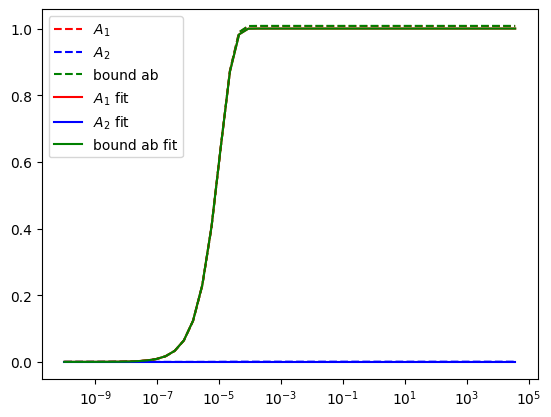

In [ ]:
sol = solve_ode_time(out.params, 1e-6)
A1_fit = sol[0]
A2_fit = sol[1]
ab_fit = (A1_fit + A2_fit)
ab = (A1 + A2)
plt.plot(t, A1, '--', label = r'$A_1$', color='red')
plt.plot(t, A2, '--', label = r'$A_2$', color='blue')
plt.plot(t, ab, '--', label = 'bound ab', color='green')
plt.plot(t, A1_fit, label = r'$A_1$' + ' fit', color='red')
plt.plot(t, A2_fit, label = r'$A_2$' + ' fit', color='blue')
plt.plot(t, ab_fit, label = 'bound ab fit', color='green')

plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [744]:
rtot_vals = np.zeros(len(noise_levels))

for j, outputs in enumerate(fits_list):
    holder = np.zeros(25)
    for i, out in enumerate(outputs):
        val = out.chisqr
        holder[i] = val
    print(holder)
    arg = np.argmin(holder)
    best_fit = outputs[arg]
    rtot_vals[j] = best_fit.params[f'koff'].value

[2.03595281e-12 8.06245744e-10 1.32886291e-09 1.27783468e-05
 4.12508529e-11 1.18424375e-05 4.11992527e-12 4.68129436e-09
 2.72330880e-12 5.35296815e-09 1.14085073e-05 2.10304969e-11
 3.82663803e-10 1.05786532e-07 1.29720125e-05 1.33428615e-10
 6.44644174e-11 1.82033737e-08 1.42783359e-09 1.18735539e-05
 6.21390492e-10 1.77124630e-10 6.17575022e-10 3.60428501e-09
 1.50774009e-11]
[8.84275961e-11 1.00815756e-09 4.63475655e-10 1.18455803e-05
 1.08517502e-09 5.43394487e-12 4.05268454e-11 4.57629386e-08
 4.14433180e-15 4.15890120e-12 3.45764382e-13 9.06585216e-10
 1.20875159e-08 1.27025432e-10 8.18033277e-10 1.08693104e-09
 1.67233725e-08 1.01674952e-09 1.33274332e-09 5.37295960e-08
 8.73048611e-13 7.40750373e-11 3.28580427e-10 1.99590354e-06
 9.56745050e-10]
[3.90504345e-10 6.23882066e-12 4.45935184e-10 1.36083581e-12
 5.98427501e-12 8.87239748e-14 3.81219221e-09 4.80747843e-07
 6.02811626e-10 1.17097411e-05 1.41484931e-09 1.13413321e-05
 1.48351950e-09 4.82212072e-11 1.28544040e-07 9.388

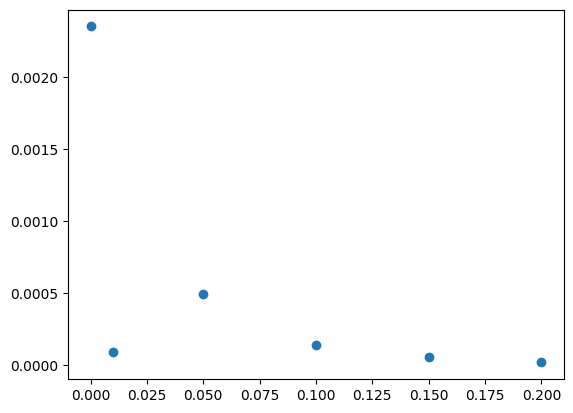

In [745]:
plt.scatter(noise_levels, rtot_vals)
plt.show()